# **Домашнее задание 7**

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH. Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [4]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 29.8 MB/s 


## Загрузка и распаковка датасета KTH

In [5]:
if 1:
    !wget http://www.csc.kth.se/cvap/actions/walking.zip
    !wget http://www.csc.kth.se/cvap/actions/jogging.zip
    !wget http://www.csc.kth.se/cvap/actions/running.zip
    !wget http://www.csc.kth.se/cvap/actions/boxing.zip
    !wget http://www.csc.kth.se/cvap/actions/handwaving.zip
    !wget http://www.csc.kth.se/cvap/actions/handclapping.zip

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

--2022-08-15 10:36:54--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-08-15 10:36:55--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   576KB/s    in 6m 51s  

2022-08-15 10:43:47 (576 KB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-08-15 10:43:47--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29

## Загрузка датасета

In [23]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [24]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset_test = dataset[SUBSET_LEN:SUBSET_LEN * 2]
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))
print('Dataset test (subset):', len(dataset_test))

Dataset samples (subset): 180
Dataset test (subset): 180


## Визуализация кадра из видео

videodata shape: (535, 120, 160, 3)


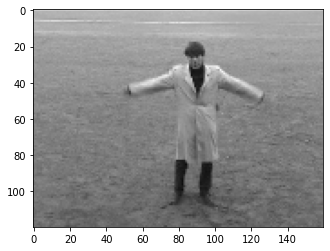

In [25]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

## Визуализация "движения"

motion shape: (534, 120, 160, 1)


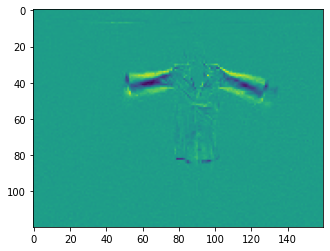

In [26]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

## Создание Датасетов


In [27]:
random.shuffle(dataset)
train_x, valid_x, train_y, valid_y = train_test_split(np.array(dataset)[:, 0],
                                                      np.array(dataset)[:, 1],
                                                      test_size=0.25, random_state=42,
                                                      stratify=np.array(dataset)[:, 1])


train_x.shape, valid_x.shape

((135,), (45,))

In [28]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [29]:
def fpath_to_video(fpath):
    fpath = fpath.numpy().decode('utf-8')
    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    # возвращаем 200 кадров из середины считанного ролика
    videodata = videodata[len(videodata)//2-100:len(videodata)//2+1+100, ...]
    return np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True) # motion

In [30]:
BATCH_SIZE = 8

train_ds = train_ds.map(lambda fpath, label: (tf.py_function(fpath_to_video, [fpath], Tout=tf.float32),
                                            tf.numpy_function(np.int8, [label], tf.int8)))
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE)


valid_ds = valid_ds.map(lambda fpath, label: (tf.py_function(fpath_to_video, [fpath], Tout=tf.float32),
                                            tf.numpy_function(np.int8, [label], tf.int8)))
valid_ds = valid_ds.shuffle(buffer_size=1000)
valid_ds = valid_ds.batch(BATCH_SIZE)

## Создание модели CNN

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

## Подготовка к обучению

In [32]:
NUM_EPOCHS = 40
LEARNING_RATE = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [33]:
for v, l in train_ds.take(1):
    print(v.shape) # video
    print(l.shape) # label
    print(model(v).shape) # output

(8, 200, 120, 160, 1)
(8,)
(8, 6)


## Цикл обучения модели

In [34]:
%%time

train_losses = []
test_losses = []

for ep in range(NUM_EPOCHS):
    for i, (videodata, labels) in enumerate(train_ds):
        train_loss = model.train_on_batch(videodata, labels)

        if i % 10 == 0:
            test_loss = model.test_on_batch(videodata, labels)
            print(f'[{ep}/{NUM_EPOCHS}][{i}/{len(train_ds)}] train loss: {train_loss} | test loss: {test_loss}')
            train_losses.append(train_loss)
            test_losses.append(test_loss)

[0/40][0/17] train loss: 1.7921032905578613 | test loss: 1.7778301239013672
[0/40][10/17] train loss: 1.785233497619629 | test loss: 1.7860419750213623
[1/40][0/17] train loss: 1.7897093296051025 | test loss: 1.789476990699768
[1/40][10/17] train loss: 1.7835381031036377 | test loss: 1.7815755605697632
[2/40][0/17] train loss: 1.7726762294769287 | test loss: 1.7658276557922363
[2/40][10/17] train loss: 1.874452829360962 | test loss: 1.8047740459442139
[3/40][0/17] train loss: 1.3952410221099854 | test loss: 1.3374460935592651
[3/40][10/17] train loss: 1.3332774639129639 | test loss: 1.1516082286834717
[4/40][0/17] train loss: 1.0429660081863403 | test loss: 0.9976524710655212
[4/40][10/17] train loss: 0.8825783729553223 | test loss: 0.8301117420196533
[5/40][0/17] train loss: 1.1377513408660889 | test loss: 1.0715134143829346
[5/40][10/17] train loss: 0.9795104265213013 | test loss: 0.94025057554245
[6/40][0/17] train loss: 0.8763620853424072 | test loss: 0.8597468137741089
[6/40][10/1

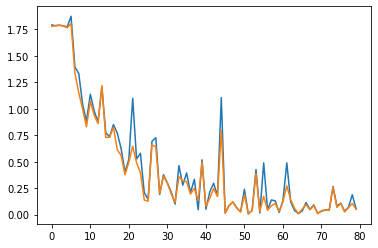

In [35]:
plt.plot(train_losses)
plt.plot(test_losses)

## Тестирование обученной модели

In [36]:
def random_prediction():
    fpath, cls_true = random.choice(dataset_test)

    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    plt.imshow(videodata[30, ...])

    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    print('True class:', classes[cls_true])
    print('Predicted class:', classes[cls_pred])

True class: walking
Predicted class: walking


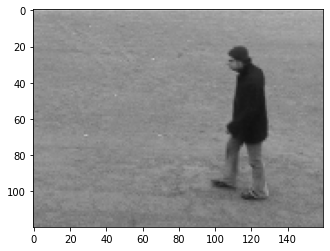

In [40]:
random_prediction()

True class: jogging
Predicted class: jogging


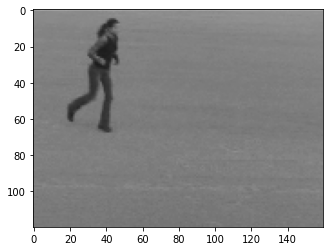

In [41]:
random_prediction()

True class: handwaving
Predicted class: handwaving


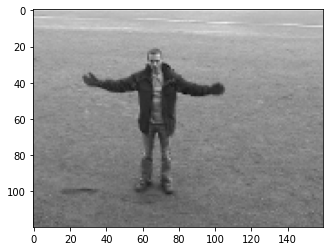

In [42]:
random_prediction()